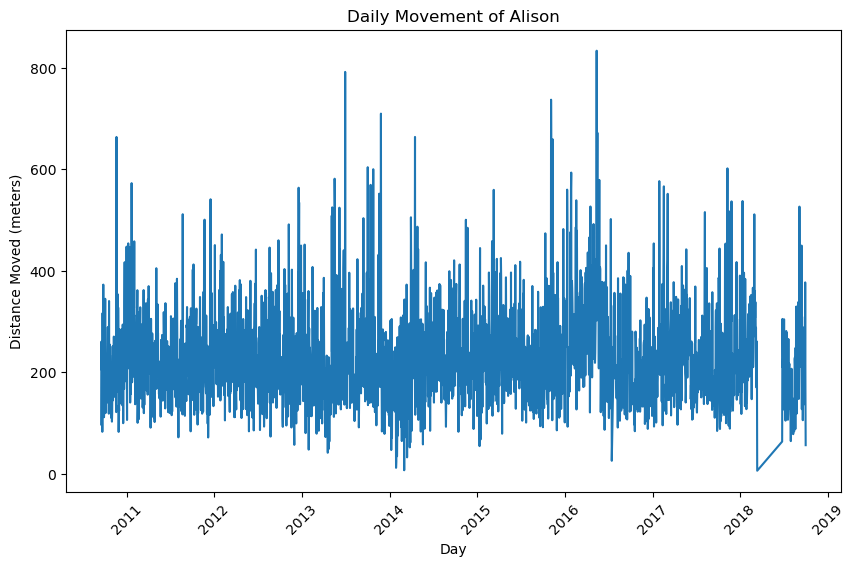

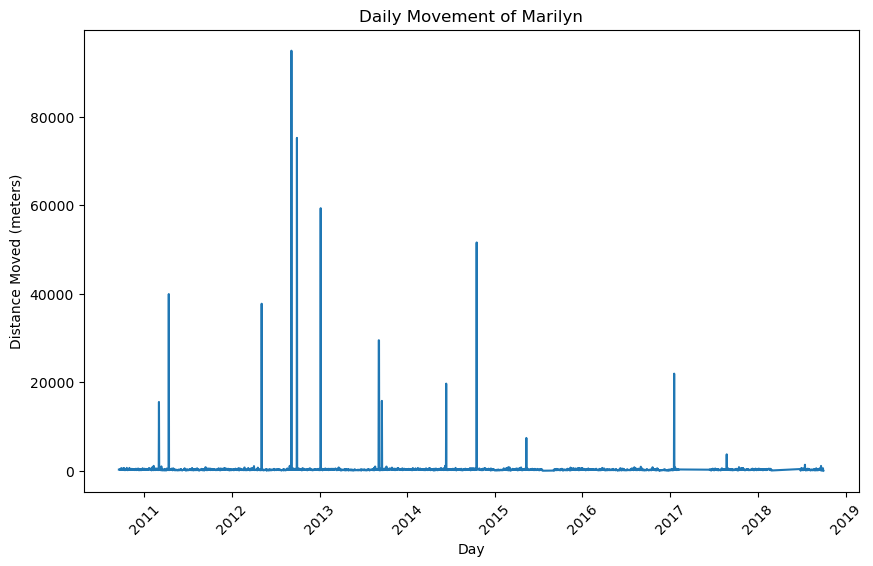

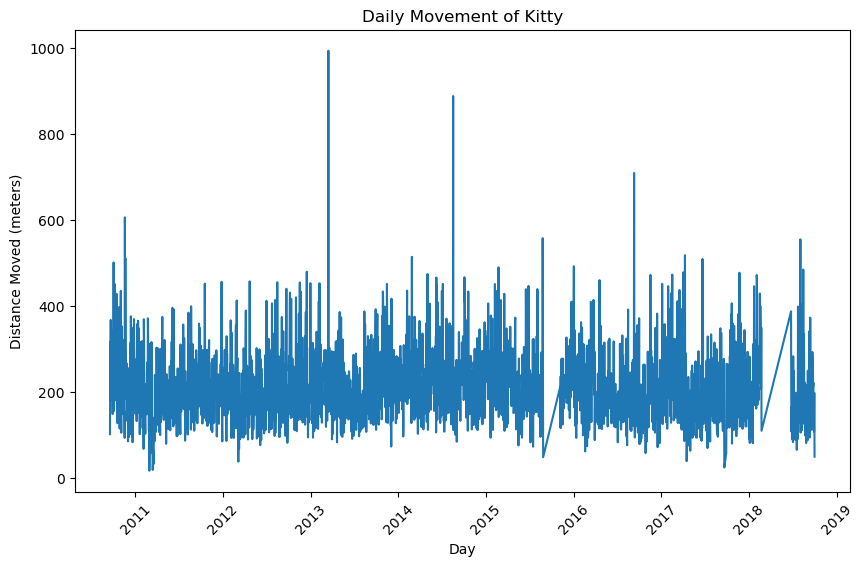

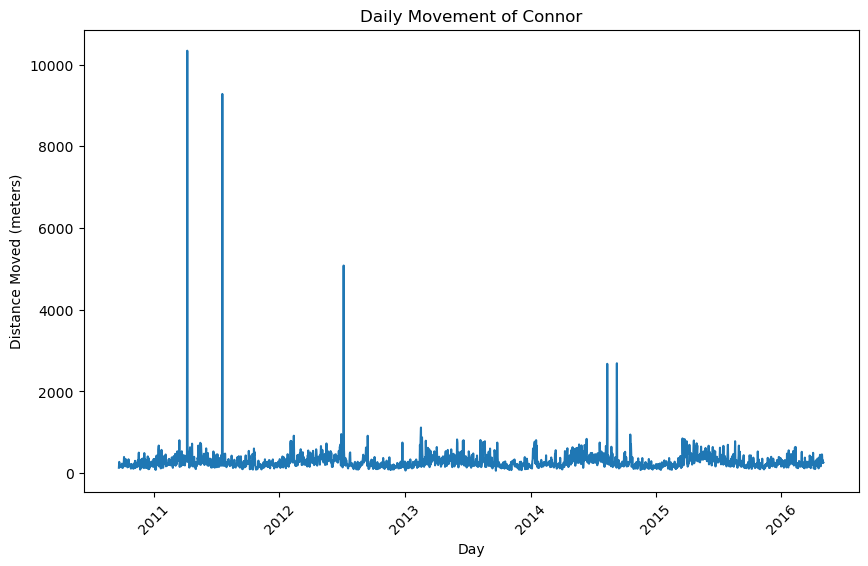

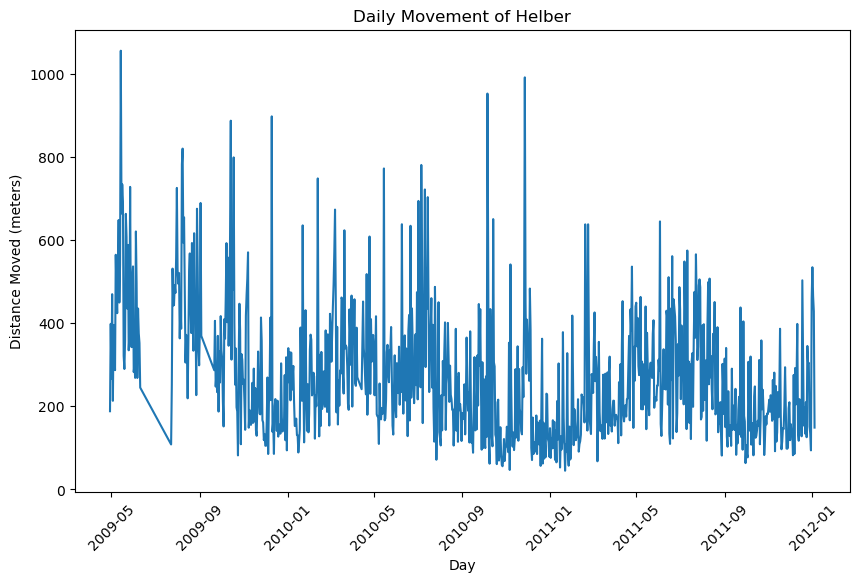

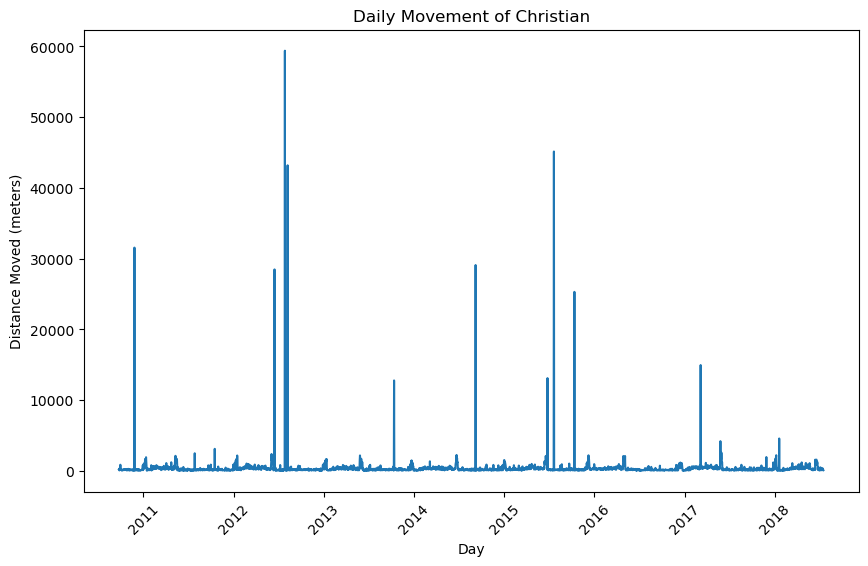

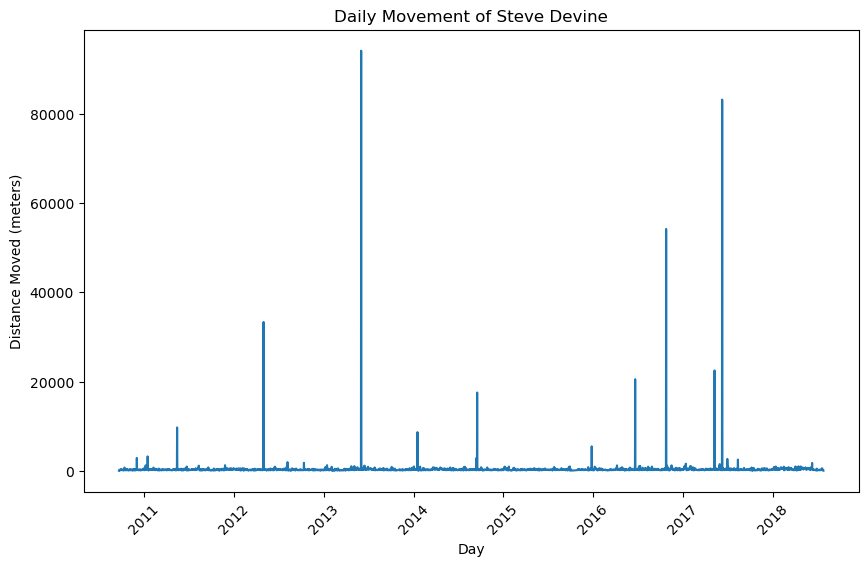

Alison migrated from 2010-09-26 to 2018-09-29
Marilyn migrated from 2011-03-03 to 2017-08-24
Kitty migrated from 2010-09-18 to 2018-09-13
Connor migrated from 2011-01-15 to 2015-08-30
Helber migrated from 2009-05-02 to 2012-01-02
Christian migrated from 2010-11-26 to 2018-01-18
Steve Devine migrated from 2011-05-15 to 2017-06-10


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

from geopy.distance import geodesic

os.chdir('C:/Users/lukeh/OneDrive/Documents/College/Topics in Data Science/Unit 2')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)


# Filter necessary columns
tortoise = tortoise[['timestamp', 'location_lat', 'location_long', 'individual_local_identifier', 'ground_speed', 'heading']]

# Haversine distance calculation
def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Add a 'day' column for daily aggregation
tortoise['day'] = tortoise['timestamp'].dt.date


# Compute daily distance traveled for each tortoise
def compute_daily_movement(df):
    df = df.sort_values(by='timestamp')
    
    # Shift the latitude and longitude columns to compute pairwise distances
    df['prev_lat'] = df['location_lat'].shift(1)
    df['prev_long'] = df['location_long'].shift(1)
    
    # Remove rows where current or previous lat/long are NaN
    df = df.dropna(subset=['location_lat', 'location_long', 'prev_lat', 'prev_long'])
    
    # Calculate daily distances
    df['daily_distance'] = df.apply(
        lambda row: haversine(row['location_lat'], row['location_long'], row['prev_lat'], row['prev_long']), axis=1
    )
    
    # Aggregate distances by day
    daily_movement = df.groupby('day')['daily_distance'].sum().reset_index()
    
    return daily_movement


# Analyze tortoises
tortoises = ['Alison', 'Marilyn', 'Kitty', 'Connor', 'Helber', 'Christian', 'Steve Devine']
migration_periods = {}

for tortoise_id in tortoises:
    tortoise_data = tortoise[tortoise['individual_local_identifier'] == tortoise_id]
    daily_movement = compute_daily_movement(tortoise_data)
    
    # Plot daily distances
    plt.figure(figsize=(10, 6))
    plt.plot(daily_movement['day'], daily_movement['daily_distance'])
    plt.title(f"Daily Movement of {tortoise_id}")
    plt.xlabel("Day")
    plt.ylabel("Distance Moved (meters)")
    plt.xticks(rotation=45)
    plt.show()

    # Detect migration days (you can customize this threshold)
    threshold = daily_movement['daily_distance'].mean() + daily_movement['daily_distance'].std()
    migration_days = daily_movement[daily_movement['daily_distance'] > threshold]
    
    # Find start and end of migration period
    if not migration_days.empty:
        start_migration = migration_days['day'].min()
        end_migration = migration_days['day'].max()
        migration_periods[tortoise_id] = (start_migration, end_migration)

# Display migration periods
for tortoise_id, period in migration_periods.items():
    print(f"{tortoise_id} migrated from {period[0]} to {period[1]}")


Findings: 
Alison has constant movement throughout the whole year with a increase in movement in the month of november 

Marilyn has a spike in movement in May and then a dip to no movement in July and August

Kitty has movement throughout the whole year with a spike in august and a steady increase in september 

Connor's movement was low in January and Febuary and then a Spike in March and then a steady descrease through the rest of the year

Helber had spikes in movement in April and October.

Christian had steady movement with a spike in June.

Steve Delvine had steady movement with a spike in May,